In [2]:
import os
import json
from copy import deepcopy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from datetime import datetime
from tqdm.notebook import tqdm
import copy
import seaborn as sns
import lovely_tensors as lt

from utils.others import w, detach_var, rsetattr, rgetattr, count_parameters, print_grads, \
    load_l2o_opter_ckpt, load_baseline_opter_ckpt, load_ckpt
from utils.visualization import get_model_dot
from training import do_fit, fit_normal, fit_optimizer
from regularization import (
    regularize_updates_translation_constraints,
    regularize_updates_scale_constraints,
    regularize_updates_rescale_constraints,
)
from analysis import (
    get_rescale_sym_constraint_deviation,
    get_translation_sym_constraint_deviations,
    get_scale_sym_constraint_deviation,
    get_baseline_opter_param_updates,
    collect_rescale_sym_deviations,
    collect_translation_sym_deviations,
    collect_scale_sym_deviations,
)
from data import MNIST
from optimizer import Optimizer
from optimizee import (
    MNISTNet,
    MNISTNet2Layer,
    MNISTNetBig,
    MNISTRelu,
    MNISTLeakyRelu,
    MNISTSimoidBatchNorm,
    MNISTReluBatchNorm,
)
from meta_module import *

lt.monkey_patch()
sns.set(color_codes=True)
sns.set_style("white")
sns.set_palette(sns.color_palette("tab10", 10))

# Compare performance of L2O optimizers
Assumes all had been meta-tested and the results were saved.

In [3]:
### l2o optimizer checkpoint directories
ckpt_root_dir = "./ckpt"
l2o_opter_ckpt_dirs = [
    "15-02-2023_15-37-09_MNISTReluBatchNorm_Optimizer", # reg_mul=0
    "16-02-2023_00-29-15_MNISTReluBatchNorm_Optimizer", # reg_mul=0.00005
    "15-02-2023_13-03-51_MNISTReluBatchNorm_Optimizer", # reg_mul=0.001
    "16-02-2023_16-16-10_MNISTReluBatchNorm_Optimizer", # reg_mul=0.001 reg all
    "16-02-2023_00-33-42_MNISTReluBatchNorm_Optimizer", # reg_mul=0.05
]
# l2o_opter_ckpt_dirs = [
#     "18-02-2023_11-30-38_MNISTLeakyRelu_Optimizer", # reg_mul=0
#     "17-02-2023_12-30-58_MNISTLeakyRelu_Optimizer", # reg_mul=0.1
#     "19-02-2023_23-46-41_MNISTLeakyRelu_Optimizer", # reg_mul=0.01
#     "16-02-2023_16-55-40_MNISTLeakyRelu_Optimizer", # reg_mul=0.001
# ]
# l2o_opter_ckpt_dirs = [
#     "18-02-2023_01-02-25_MNISTNet_Optimizer", # reg_mul=0
#     "16-02-2023_17-03-09_MNISTNet_Optimizer", # reg_mul=0.01
#     "19-02-2023_01-09-37_MNISTNet_Optimizer", # reg_mul=0.01 reg all
#     "19-02-2023_01-03-19_MNISTNet_Optimizer", # reg_mul=0.1
#     "18-02-2023_00-55-52_MNISTNet_Optimizer", # reg_mul=0.3 reg all
# ]
l2o_opter_ckpt_dirs = [os.path.join(ckpt_root_dir, d) for d in l2o_opter_ckpt_dirs]

### plot baselines as well (loads from saved results)
baselines_dir = "./ckpt/baselines"
baselines_to_test_against = [
    ("Adam", optim.Adam, {"lr": 0.03}),
    # ("RMSprop", optim.RMSprop, {"lr": 0.003}),
    ("SGD", optim.SGD, {"lr": 0.1, "momentum": 0.9}),
    # ("NAG", optim.SGD, {"lr": 0.1, "nesterov": True, "momentum": 0.9})
]

### optimizees to compare on
optees_to_test = [
    (MNISTNet2Layer, {}),
    (MNISTNetBig, {}),
    (MNISTRelu, {}),
    (MNISTLeakyRelu, {}),
    (MNISTReluBatchNorm, {"affine": True, "track_running_stats": False}),
    (MNISTNet, {}),
]

In [4]:
### load baseline metrics from disk
baseline_metrics = dict()

for optee_cls, optee_config in optees_to_test:
    baseline_metrics[f"{optee_cls.__name__}_{optee_config}"] = dict()
    for (opter_name, baseline_opter_cls, extra_kwargs) in baselines_to_test_against:
        metrics_file_name = f"metrics_{opter_name}_{extra_kwargs}_{optee_cls.__name__}_{optee_config}.npy"
        print(f"Loading {metrics_file_name}")
        baseline_metrics[f"{optee_cls.__name__}_{optee_config}"][opter_name] = np.load(os.path.join(baselines_dir, metrics_file_name), allow_pickle=True).item()

Loading metrics_Adam_{'lr': 0.03}_MNISTNet2Layer_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet2Layer_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTNetBig_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNetBig_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTRelu_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTRelu_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTLeakyRelu_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTLeakyRelu_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTNet_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet_{}.npy


In [5]:
### load all l2o opters from disk (results of meta-testing + configs)
l2o_opters = []

for l2o_opter_ckpt_dir in l2o_opter_ckpt_dirs:
    ### load previous checkpoint (and skip meta-training of a new l2O optimizer)
    _, config, _ = load_ckpt(dir_path=l2o_opter_ckpt_dir)
    assert l2o_opter_ckpt_dir == config["ckpt_base_dir"]
    l2o_opter_dict = {
        "l2o_opter_ckpt_dir": l2o_opter_ckpt_dir,
        "config": config,
        "metrics": dict(),
    }

    for metrics_file in [f_name for f_name in os.listdir(config["ckpt_base_dir"]) if f_name.startswith("metrics_")]:
        metrics_name = metrics_file[8:-4] # remove the "metrics_" prefix and ".npy" suffix
        l2o_opter_dict["metrics"][metrics_name] = np.load(os.path.join(config["ckpt_base_dir"], metrics_file), allow_pickle=True).item()
    
    l2o_opters.append(l2o_opter_dict)

## Plot

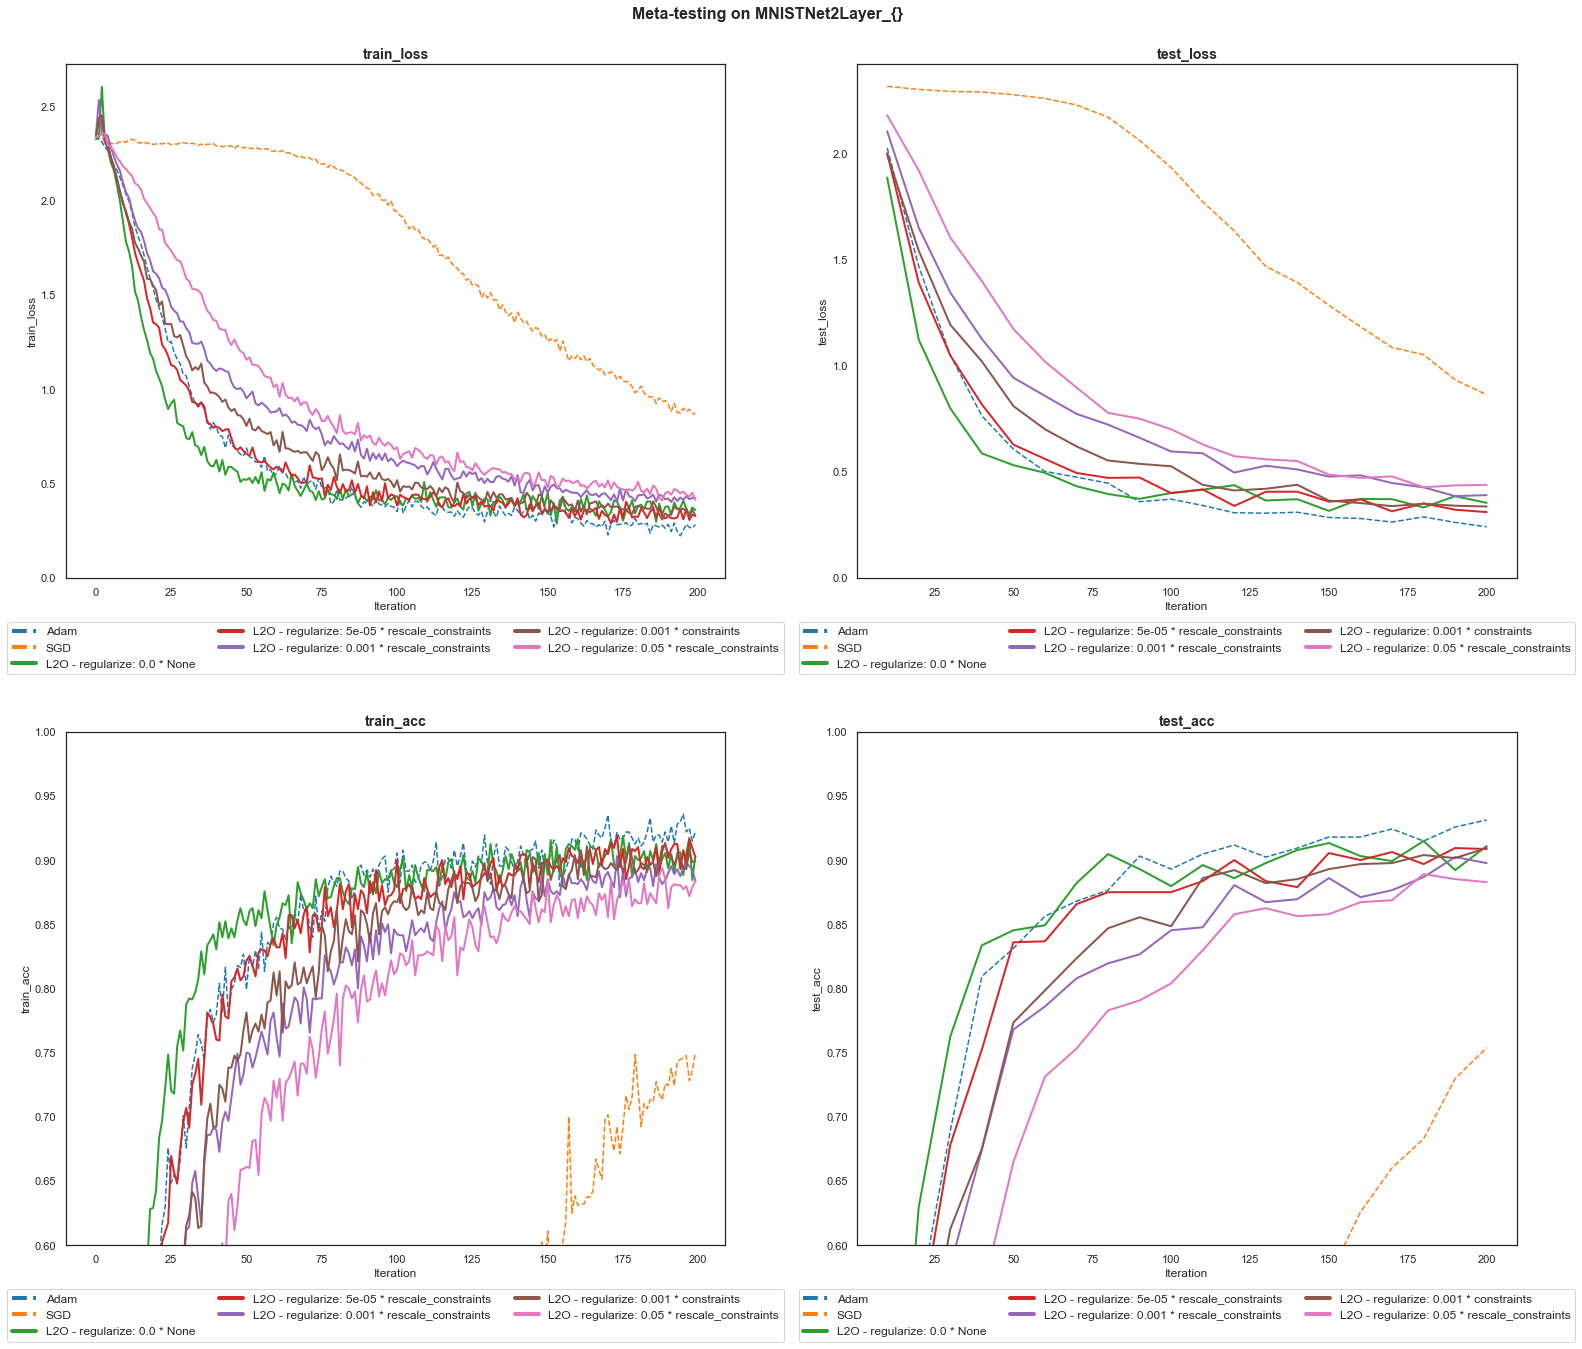

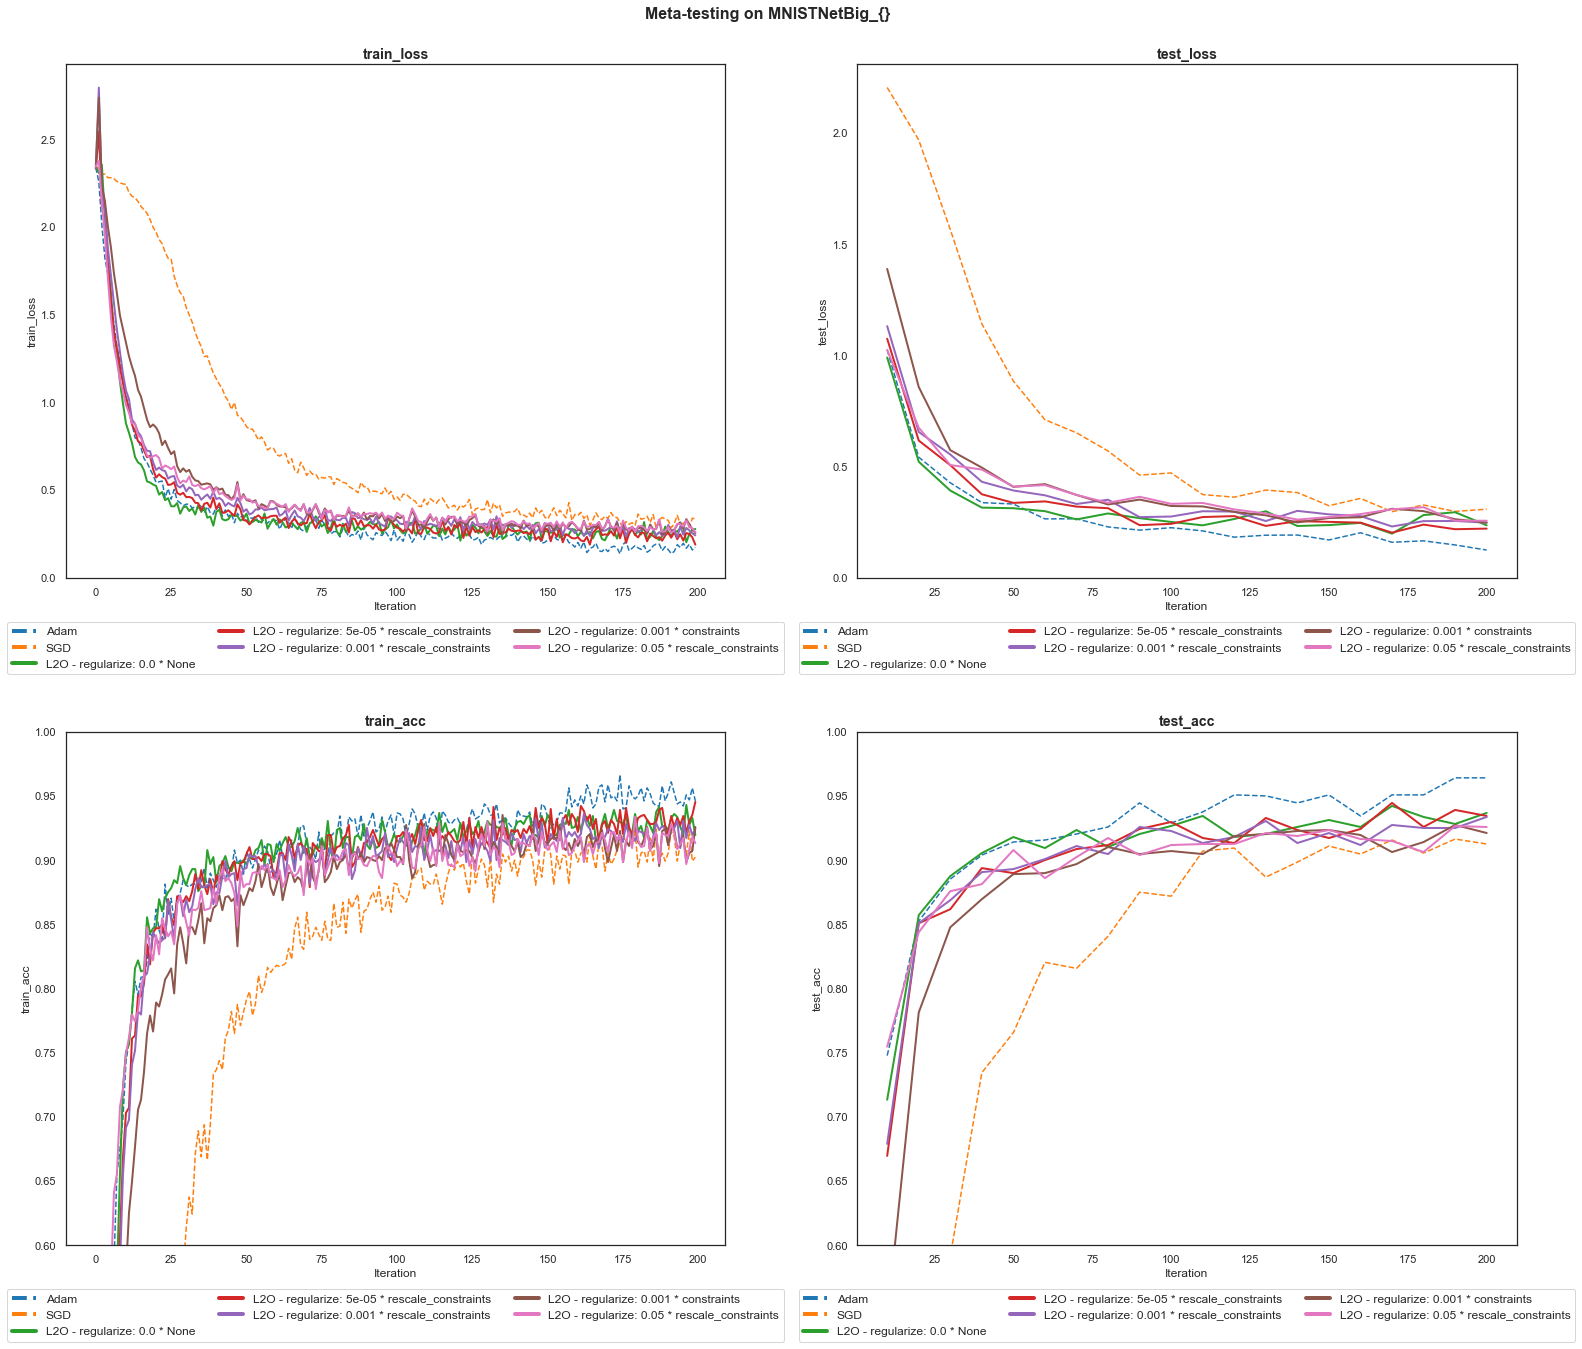

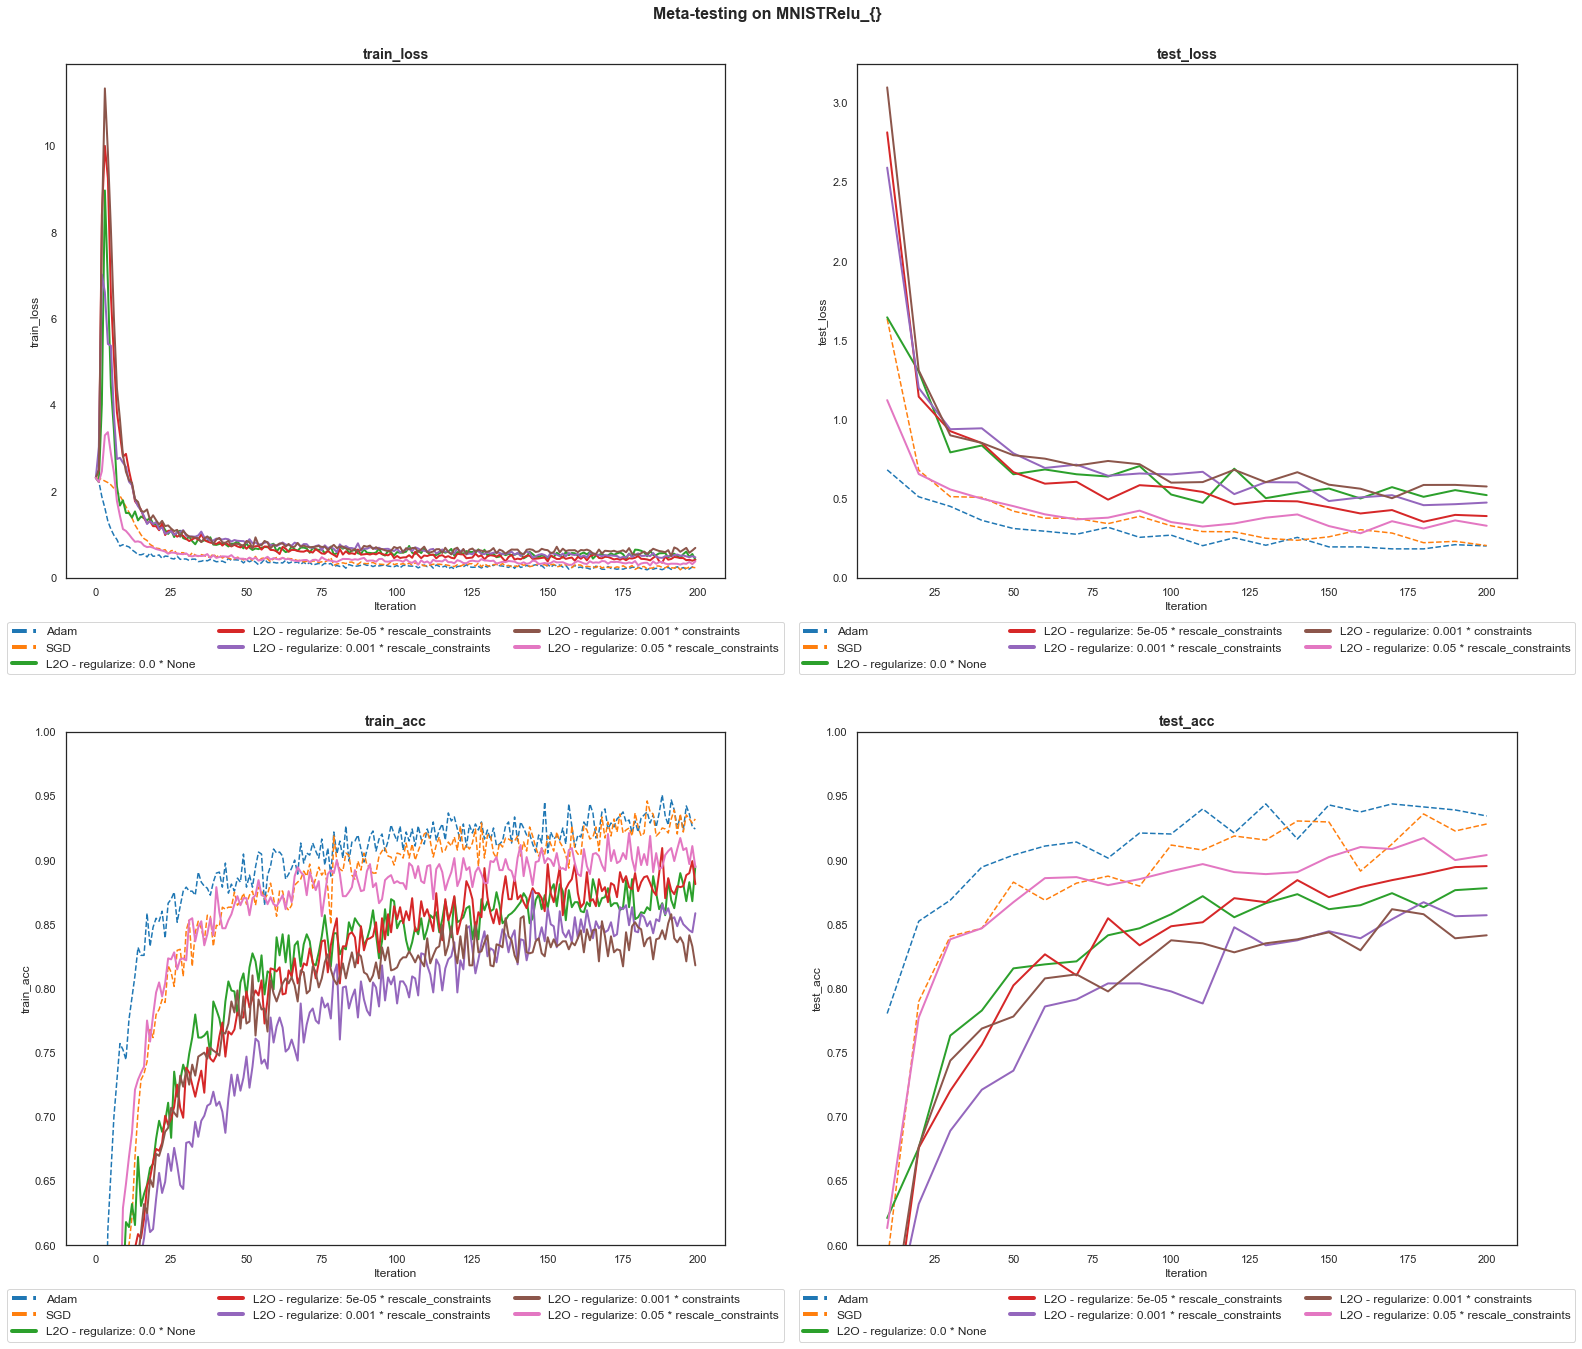

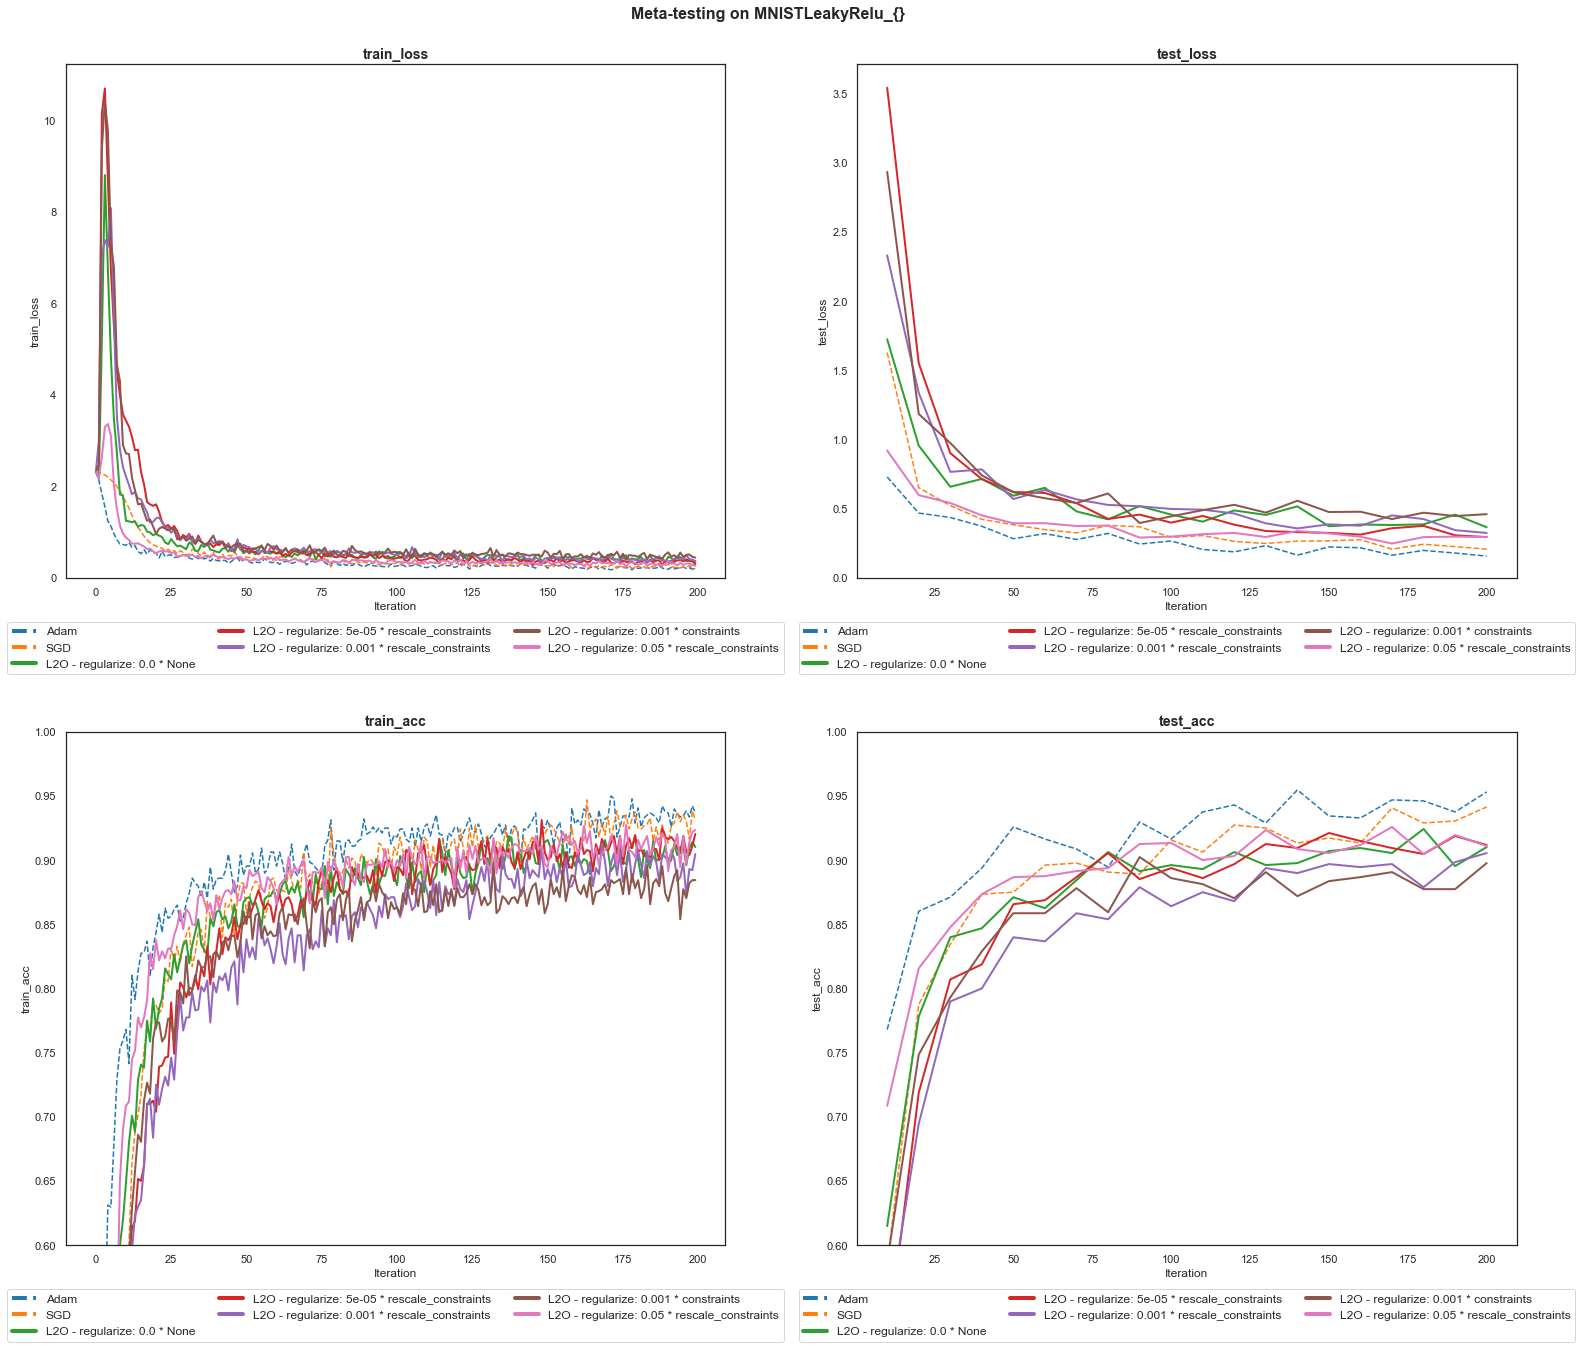

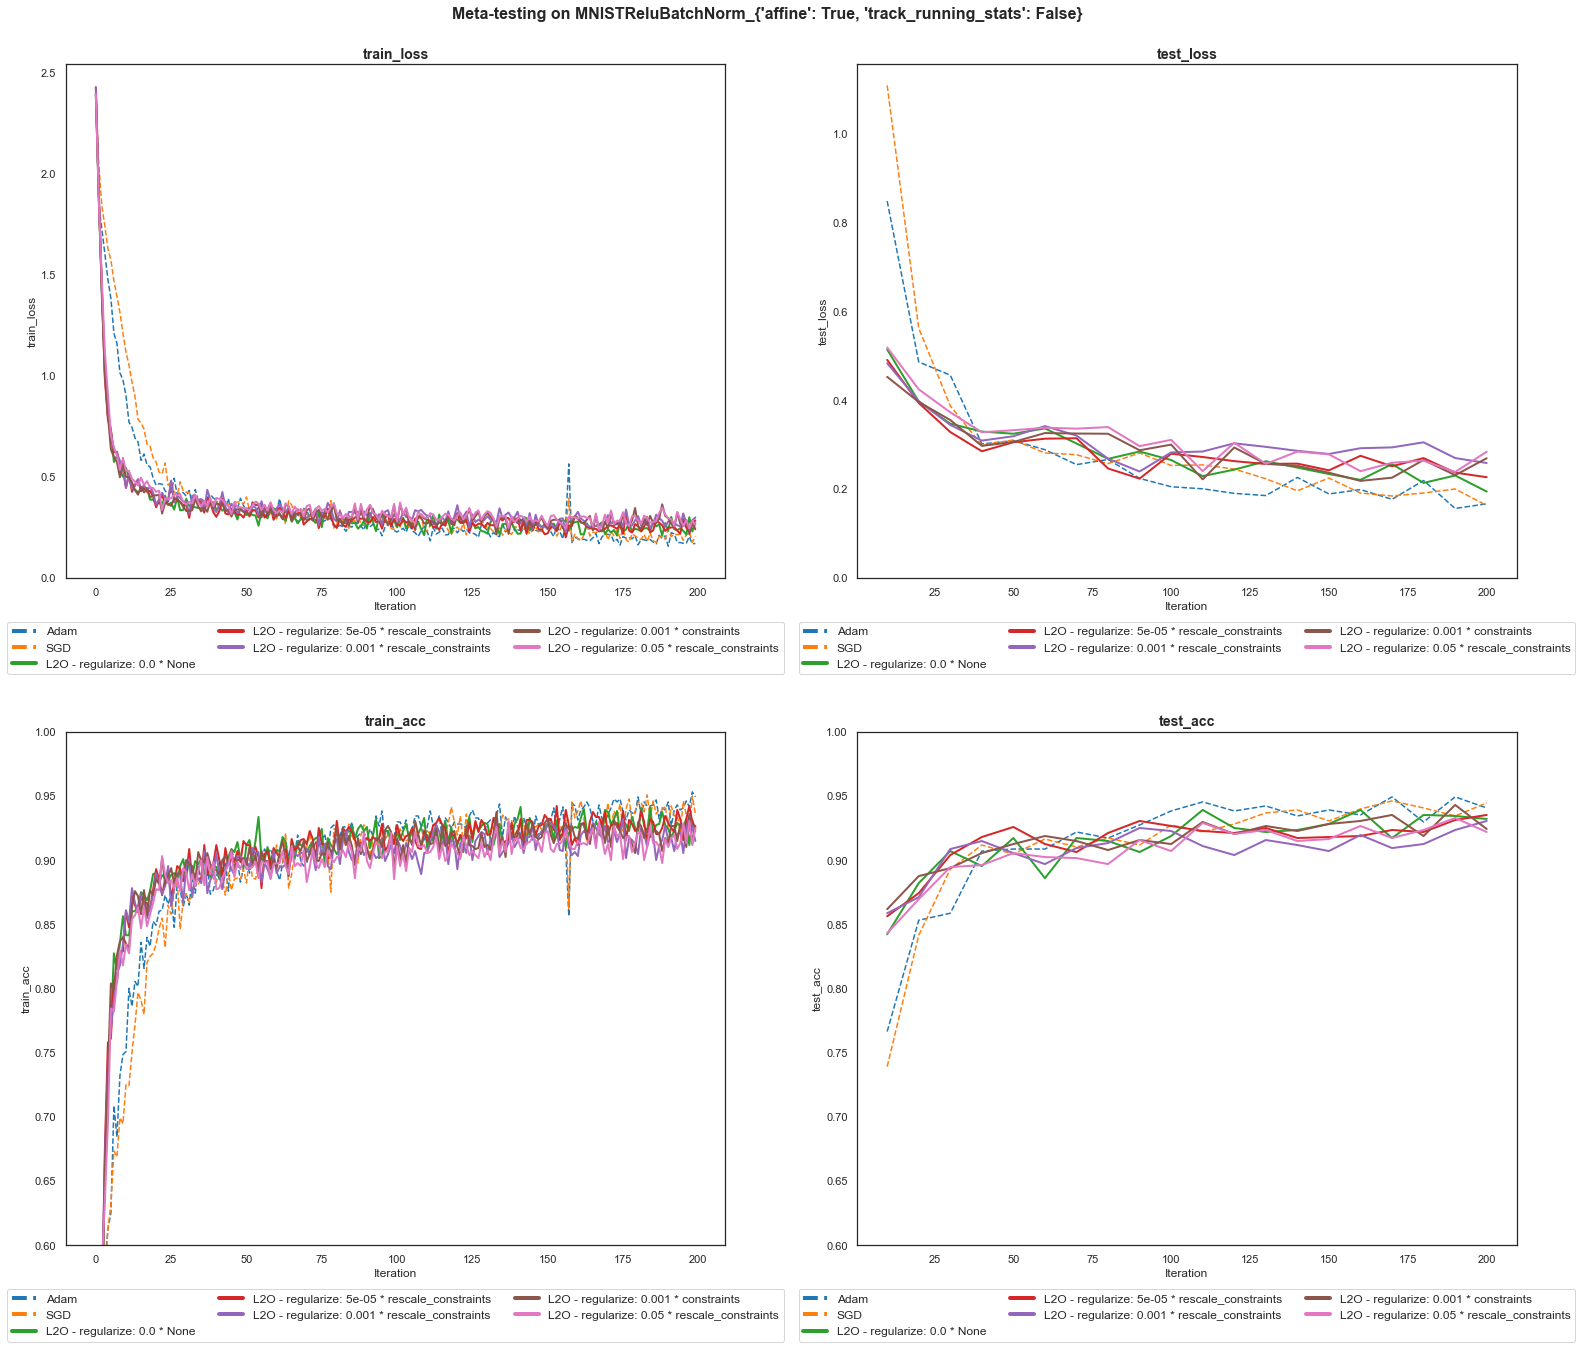

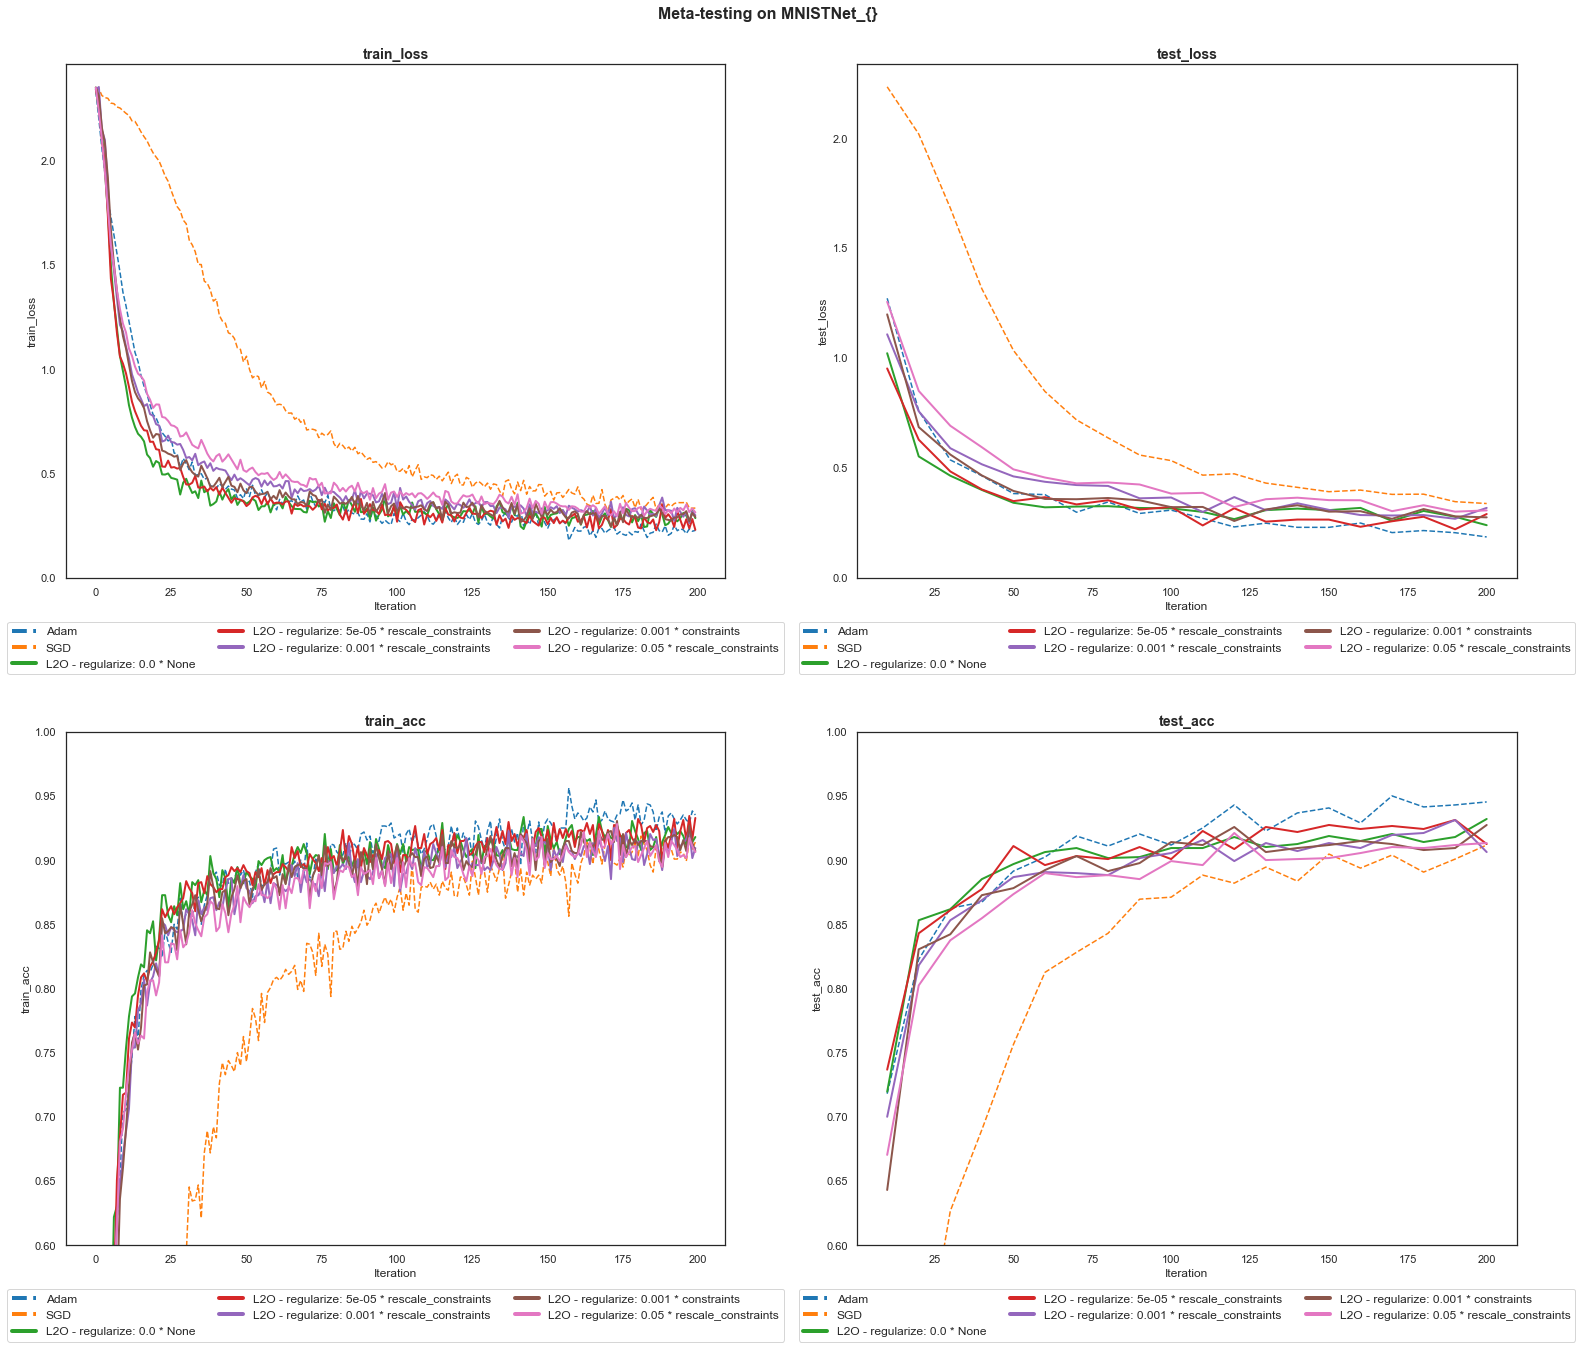

In [9]:
show_max_iters = 200
log_loss = False
# save_figs_to_dir = ckpt_root_dir
save_figs_to_dir = "./results/imgs/regularization/MNISTReluBatchNorm_meta_training"

for optee_cls, optee_config in optees_to_test:
    optee_nickname = f"{optee_cls.__name__}_{optee_config}"
    curr_baseline_metrics = baseline_metrics[optee_nickname]

    ### plot comparison
    fig = plt.figure(figsize=(26, 16))
    for m_i, metric in enumerate(["train_loss", "test_loss", "train_acc", "test_acc"]):
        ax = fig.add_subplot(2, 2, m_i + 1)
        
        ### baseline optimizers
        for opter_name, opter_metrics in curr_baseline_metrics.items():
            if "test" in metric:
                x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
                y = np.mean(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
                y_min = np.min(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
                y_max = np.max(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
            else:
                x = range(opter_metrics[metric][:,:show_max_iters].shape[1])
                y = np.mean(opter_metrics[metric][:,:show_max_iters], axis=0)
                y_min = np.min(opter_metrics[metric][:,:show_max_iters], axis=0)
                y_max = np.max(opter_metrics[metric][:,:show_max_iters], axis=0)
            sns.lineplot(
                x=x,
                y=y,
                label=opter_name,
                linestyle="--",
                ax=ax,
            )
            # ax.fill_between(
            #     x=x,
            #     y1=y_min,
            #     y2=y_max,
            #     alpha=0.1,
            # )

        ### L2O optimizers
        for l2o_opter_dict in l2o_opters:
            if optee_nickname not in l2o_opter_dict["metrics"]:
                print(f"Skipping {optee_nickname} for {l2o_opter_dict['l2o_opter_ckpt_dir']}, not found in metrics")
                continue
            metrics = l2o_opter_dict["metrics"][optee_nickname]
            config = l2o_opter_dict["config"]

            if "test" in metric:
                x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
                y = np.mean(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
                y_min = np.min(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
                y_max = np.max(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
            else:
                x = range(metrics[metric][:,:show_max_iters].shape[1])
                y = np.mean(metrics[metric][:,:show_max_iters], axis=0)
                y_min = np.min(metrics[metric][:,:show_max_iters], axis=0)
                y_max = np.max(metrics[metric][:,:show_max_iters], axis=0)

            reg_func_name = config['meta_training']['opter_updates_reg_func'].__name__.replace("regularize_updates_", "") if config['meta_training']['opter_updates_reg_func'] is not None else "None"
            sns.lineplot(
                x=x,
                y=y,
                label=f"L2O - regularize: {config['meta_training']['reg_mul']} * {reg_func_name}",
                # label=f"L2O - {l2o_opter_dict['l2o_opter_ckpt_dir']}",
                # color="orange",
                linewidth=2,
                ax=ax,
            )
            # ax.fill_between(
            #     x=x,
            #     y1=y_min,
            #     y2=y_max,
            #     alpha=0.1,
            #     # color="orange",
            # )
            
        ### plot settings
        ax.set_title(metric, fontsize=14, fontweight="bold")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(metric)
        # set y to log scale
        if log_loss and "loss" in metric:
            ax.set_yscale("log")

        if "acc" in metric:
            ax.set_ylim(0.6, 1.0)
        else:
            ax.set_ylim(0.0, None)
        legend = ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=12, frameon=True)
        for legend_handle in legend.legendHandles:
            legend_handle.set_linewidth(4.0)

    fig.suptitle(f"Meta-testing on {optee_nickname}", fontsize=16, fontweight="bold", y=1.2)
    fig.subplots_adjust(hspace=0.3, top=1.15)
    plt.show()

    ### save the figure
    fig.savefig(
        os.path.join(save_figs_to_dir, f"log_losses_comparison_{optee_nickname}.png" if log_loss else f"losses_comparison_{optee_nickname}.png"),
        bbox_inches="tight"
    )